In [2]:
import sys
sys.path.append('../')
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

### Exercise 1

* Gamma prior distribution

Firstly, there is a need to prepere prior distribution. Parameters are set due to own speculations and intuition.

In [3]:
with open('my_model_prior.stan', 'r') as file:
    print(file.read())

data {
	vector[2] params; 
}

generated quantities {
  real y = gamma_rng (params[1], params[2]);
}


Parameters are set to: alpha = 1 and beta = 2

In [5]:
from pystan import StanModel
tuning2 = StanModel('my_model_prior.stan')

params = [1, 2]
data=dict(params = params)
tuned2 = tuning2.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1000, 
                          warmup=0,
                          chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_656bbc4d88987fb6fc8bd7adc5eb5943 NOW.


Now, after compiling the model, it is possible to plot results.

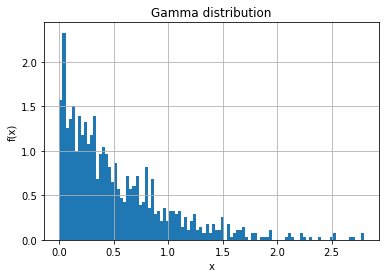

In [24]:
y = tuned2.extract()['y']
plt.hist(y, 100, density=True, cumulative=False)
plt.title('Gamma distribution')
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

* Gamma likelihood distribution

After creating prior distribution, stan's likelihood distribution may be compiled.

In [64]:
with open('my_model.stan', 'r') as file:
    print(file.read())

functions {

  vector tail_delta(vector y, vector params, real[] x_r, int[] x_i) {
    vector[2] deltas;
    deltas[1] = gamma_cdf(params[1], exp(y[1]), exp(y[2]));
	deltas[2] = gamma_cdf(params[2], exp(y[1]), exp(y[2]))- 0.98;
    return deltas;
  }
}

data {
  vector[2] y_guess;
  vector[2] params; 
}

transformed data {

  vector[2] y;
  real x_r[0];
  int x_i[0];

  y = algebra_solver(tail_delta, y_guess, params, x_r, x_i);
}

generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}


Parameters are set such that: alpha = 5, beta = 10 as we want to have 98% probability beetwen that values.

In [65]:
params = np.array([5, 10])
y_guess = np.array([np.log(8), np.log(1)])
print(y_guess)

[2.07944154 0.        ]


In [66]:
from pystan import StanModel
tuning2 = StanModel('my_model.stan')

data=dict(y_guess = y_guess, params = params)
tuned2 = tuning2.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1000, 
                          warmup=0,
                          chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_786ab9a839a061cf718e13235bcebedd NOW.


RuntimeError: Exception: algebra_solver: the norm of the algebraic function is: 6.67769e-006 but should be lower than the function tolerance: 1e-006. Consider decreasing the relative tolerance and increasing the max_num_steps.  (in 'my_model.stan' at line 22)


Counted by stan's model results are printed below.

In [41]:
alpha = np.round(tuned2.extract()['alpha'][0])
print(alpha)
beta = np.round(tuned2.extract()['beta'][0])
print(beta)

47.0
7.0


We can print gamma distribution and compare it with a prior model distribution.

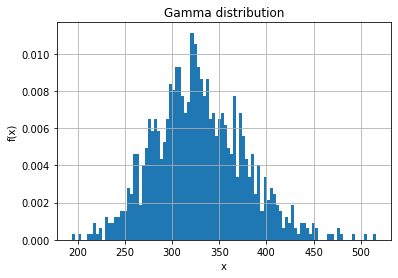

In [42]:
samples = np.random.gamma(alpha, beta, 1000)
plt.hist(samples, 100, density=True, cumulative=False)
plt.title('Gamma distribution')
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

* invGamma prior distribution

When it comes to inv_gamma similar things are done as it is above with gamma distribution.

In [67]:
with open('inv-gamma-prior.stan', 'r') as file:
    print(file.read())

data {
	vector[2] params; 
}

generated quantities {
  real y = inv_gamma_rng (params[1], params[2]);
}


In [68]:
from pystan import StanModel
tuning2 = StanModel('inv-gamma-prior.stan')

params = [1, 2]
data=dict(params = params)
tuned2 = tuning2.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1000, 
                          warmup=0,
                          chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_505ce17ab424a3cfab8dabcdda6344c4 NOW.


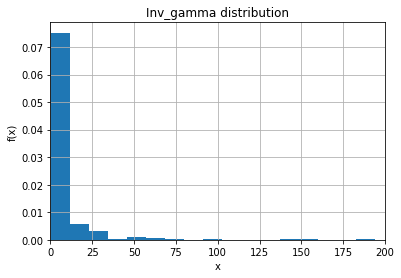

In [70]:
y = tuned2.extract()['y']
plt.hist(y, 100, density=True, cumulative=False)
plt.title('Inv_gamma distribution')
plt.grid()
plt.xlim(0, 200)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

* Inv_gamma likelihood distribution

In [71]:
with open('inv-gamma.stan', 'r') as file:
    print(file.read())

functions {

  vector tail_delta(vector y, vector params, real[] x_r, int[] x_i) {
    vector[2] deltas;
	deltas[1] = inv_gamma_cdf(params[1], exp(y[1]), exp(y[2]));
    deltas[2] = inv_gamma_cdf(params[2], exp(y[1]), exp(y[2])) - 0.98;
    return deltas;
  }
}

data {
  vector[2] y_guess;
  vector[2] params; 
}

transformed data {

  vector[2] y;
  real x_r[0];
  int x_i[0];

  y = algebra_solver(tail_delta, y_guess, params, x_r, x_i);
}

generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}


In [72]:
params = np.array([5, 10])
y_guess = np.array([np.log(8), np.log(1)])
print(params)

[ 5 10]


In [73]:
from pystan import StanModel
model = StanModel('inv-gamma.stan')

data=dict(y_guess = y_guess, params = params)
model = model.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1000, 
                          warmup=0,
                          chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d6baf331aa9c08fd9de64902ae42bb01 NOW.


ValueError: Exception: Exception: inv_gamma_cdf: Scale parameter is inf, but must be finite!  (in 'inv-gamma.stan' at line 5)
  (in 'inv-gamma.stan' at line 22)


In [55]:
alpha = np.round(model.extract()['alpha'][0])
print(alpha)
beta = np.round(model.extract()['beta'][0])
print(beta)

47.0
7.0


### Exercise 2

Starting with creating stan models for both, neg_binomial and poisson distribution. As thay have to have the same mean, functions takes the same value as a function parameter.

In [83]:
with open('zad2.stan', 'r') as file:
    print(file.read())


data {
  real mu; 
  real phi;
}

generated quantities {
  real y_neg_binomial = neg_binomial_rng(mu, phi);
  int y_poisson = poisson_rng(mu);
}


Mean will be equal to 9.

In [84]:
mu_ = 9
phi_ = 0.1

model = StanModel('zad2.stan')

data=dict(mu = mu_, phi = phi_)
model = model.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1000, 
                          warmup=0,
                          chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_672efa04dc558646a95ea4994dd490a3 NOW.


In [85]:
neg_bin_values = model.extract()['y_neg_binomial']
poisson_values = model.extract()['y_poisson']

Now distributions are printed in order to be compared.

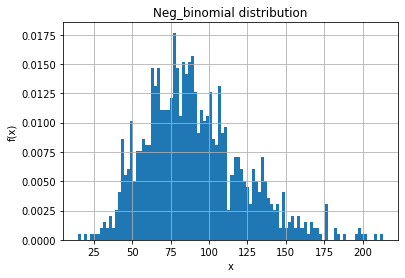

In [88]:
plt.hist(neg_bin_values, 100, density=True, cumulative=False)
plt.title('Neg_binomial distribution')
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

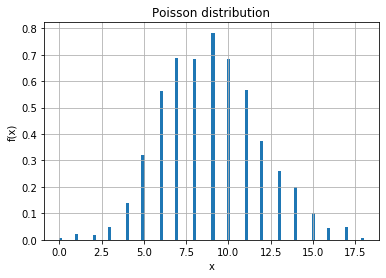

In [89]:
plt.hist(poisson_values, 100, density=True, cumulative=False)
plt.title('Poisson distribution')
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

We can see that Poisson distribution decreases much faster in comparison to neg_binomial distribution.

### Exercise 3

Starting with creating stan models for both, student_t and normal distribution. Both distributions are using the same values of parameters.

In [94]:
with open('student_t.stan', 'r') as file:
    print(file.read())

data {
  vector[3] params; 
}

generated quantities {

real student_t_results = student_t_rng(params[1], params[2], params[3]);
real normal_results = normal_rng(params[2], params[3]);
}


Below we will see how changing different parameters influence distributions.

* Changing nu parameter 

We might print all distributions in order to compare them with each other and see how changing nu parameter has influenced them.

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.


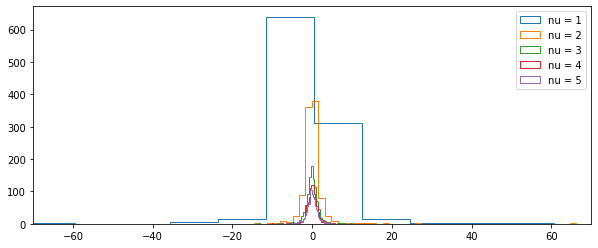

In [116]:
model = StanModel('student_t.stan')
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for i in range(1, 6):
    model = StanModel('student_t.stan')
    data = dict(params = [i, 0, 1])
    model = model.sampling(data=data,seed=1052020,algorithm="Fixed_param",iter=1000, warmup=0,chains=1)
    x = model.extract()['student_t_results']
    plt.hist(x, bins = 50, histtype = 'step')
plt.xlim(-70, 70)
plt.legend(['nu = 1' ,'nu = 2', 'nu = 3', 'nu = 4', 'nu = 5', 'nu = 6'])
plt.show()

Now we are printing Normal distribution in order to be able to compare it with above student_t distributions. It is visible that 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.


(array([ 2.,  1.,  0.,  1.,  2.,  0.,  3.,  9., 10., 12.,  8.,  5., 15.,
        12., 29., 31., 33., 31., 32., 40., 61., 58., 41., 35., 52., 50.,
        46., 45., 57., 44., 33., 37., 33., 25., 26., 11., 16.,  9., 13.,
        14.,  3.,  2.,  3.,  3.,  1.,  3.,  0.,  1.,  1.,  1.]),
 array([-3.16042092, -3.0298504 , -2.89927989, -2.76870938, -2.63813886,
        -2.50756835, -2.37699784, -2.24642733, -2.11585681, -1.9852863 ,
        -1.85471579, -1.72414527, -1.59357476, -1.46300425, -1.33243374,
        -1.20186322, -1.07129271, -0.9407222 , -0.81015168, -0.67958117,
        -0.54901066, -0.41844015, -0.28786963, -0.15729912, -0.02672861,
         0.10384191,  0.23441242,  0.36498293,  0.49555344,  0.62612396,
         0.75669447,  0.88726498,  1.0178355 ,  1.14840601,  1.27897652,
         1.40954703,  1.54011755,  1.67068806,  1.80125857,  1.93182909,
         2.0623996 ,  2.19297011,  2.32354062,  2.45411114,  2.58468165,
         2.71525216,  2.84582268,  2.97639319,  3.1069637 ,

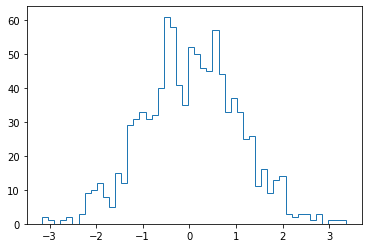

In [112]:
model = StanModel('student_t.stan')
data = dict(params = [1, 0, 1])
model = model.sampling(data=data,seed=1052020,algorithm="Fixed_param",iter=1000, warmup=0,chains=1)
x = model.extract()['normal_results']
plt.hist(x, bins = 50, histtype = 'step')

We can see that the greater value is set to nu parameter, the more the distribution look like the normal one. 

* Changing mu parameter

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.


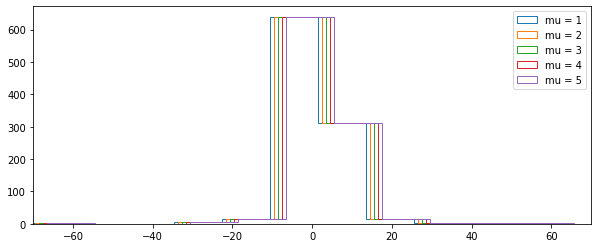

In [118]:
model = StanModel('student_t.stan')
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for i in range(1, 6):
    model = StanModel('student_t.stan')
    data = dict(params = [1, i, 1])
    model = model.sampling(data=data,seed=1052020,algorithm="Fixed_param",iter=1000, warmup=0,chains=1)
    x = model.extract()['student_t_results']
    plt.hist(x, bins = 50, histtype = 'step')
plt.xlim(-70, 70)
plt.legend(['mu = 1' ,'mu = 2', 'mu = 3', 'mu = 4', 'mu = 5', 'mu = 6'])
plt.show()

Incrementing mu parameter couses moving the center (mean) to left or right, depending of whether the value is positive or negative.

* Changing sigma parameter

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.


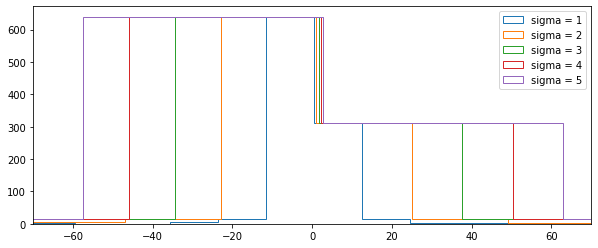

In [119]:
model = StanModel('student_t.stan')
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for i in range(1, 6):
    model = StanModel('student_t.stan')
    data = dict(params = [1, 0, i])
    model = model.sampling(data=data,seed=1052020,algorithm="Fixed_param",iter=1000, warmup=0,chains=1)
    x = model.extract()['student_t_results']
    plt.hist(x, bins = 50, histtype = 'step')
plt.xlim(-70, 70)
plt.legend(['sigma = 1' ,'sigma = 2', 'sigma = 3', 'sigma = 4', 'sigma = 5', 'sigma = 6'])
plt.show()

The greater value we set to sigma, the greater the range is.

* Changing numer of samples in order to check how mead and variance are changing 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.


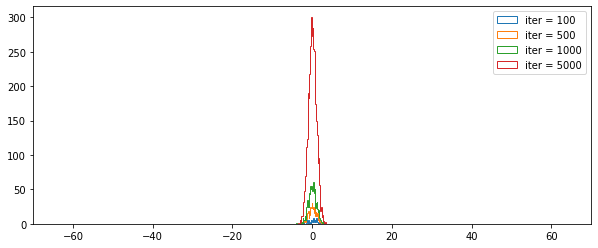

In [120]:
model = StanModel('student_t.stan')
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
data_values = [100, 500, 1000, 5000]

for i in data_values:
    model = StanModel('student_t.stan')
    data = dict(params = [i, 0, 1])
    model = model.sampling(data=data,seed=1052020,algorithm="Fixed_param",iter=i, warmup=0,chains=1)
    x = model.extract()['student_t_results']
    plt.hist(x, bins = 50, histtype = 'step')
plt.xlim(-70, 70)
plt.legend(['iter = 100' ,'iter = 500', 'iter = 1000', 'iter = 5000'])
plt.show()

### Exercise 4

In [121]:
with open('multi_normal.stan', 'r') as file:
    print(file.read())

data {
    vector[2] mu;
    matrix[2, 2] sigma;
}
generated quantities {
    vector[2] y = multi_normal_rng(mu, sigma);
}


In [124]:
model = StanModel('multi_normal.stan')
data = {'mu': np.array([0, 0]), 'sigma': np.array([[1, 0.5], [0.5, 1]])}
model = model.sampling(data=data,seed=1052020,algorithm="Fixed_param",iter=i, warmup=0,chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1ba3c7cd858044f25b8de80e17ce187e NOW.


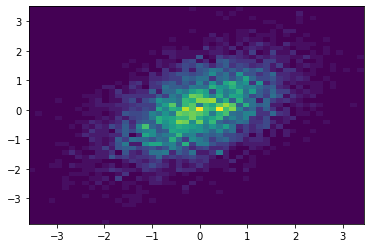

In [144]:
y = model.extract()['y']
y = pd.DataFrame(y)
y.columns = ['x', 'y']
plt.hist2d(y['x'], y['y'], bins = 50)
plt.show()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f82ea1e4d29c51ce238a32112c58d87c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1ba3c7cd858044f25b8de80e17ce187e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1ba3c7cd858044f25b8de80e17ce187e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1ba3c7cd858044f25b8de80e17ce187e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1ba3c7cd858044f25b8de80e17ce187e NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1ba3c7cd858044f25b8de80e17ce187e NOW.


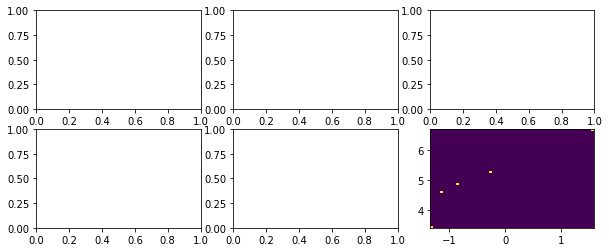

In [145]:
model = StanModel('student_t.stan')
fig, ax = plt.subplots(2, 3, figsize=(10, 4))

for i in range(1, 6):
    model = StanModel('multi_normal.stan')
    data = {'mu': np.array([0, i]), 'sigma': np.array([[1, 0.5], [0.5, 1]])}
    model = model.sampling(data=data,seed=1052020,algorithm="Fixed_param",iter=i, warmup=0,chains=1)
    y = model.extract()['y']
    y = pd.DataFrame(y)
    y.columns = ['x', 'y']
    plt.hist2d(y['x'], y['y'], bins = 50)

plt.show()